In [3]:
from cskpd import *
from interface import *
from statsmodels.genmod.families.links import Logit
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
g = Logit()
C_true = np.load("Examples/circles.npy")
np.random.seed(539)
## image shape
img_shape_m,img_shape_n,img_shape_d = 128,128,1
## sample size 
N = 1000
## noise level
sigma = 3
epsilon = np.random.normal(0,1,N) * sigma
X = np.random.normal(0,1,[N, img_shape_m, img_shape_n, img_shape_d]).squeeze()
Y = np.round(g.inverse(np.tensordot(X, C_true, axes=([1,2], [0,1])) + epsilon),0)

In [ ]:
## lambda 1 candidate, corresponds to the lambda in the paper
lmbda_set = [0.4,0.6,1]
## We set lambda2 equals 0 all the time in the paper.
lmbda2_set = [0]
## tuning R in this candidate set
## We refer to implement R = 1 first when smaple size is limited
R_list = [1,2,3]
n_cores = 4
## the dim of underlying C is (D1,D2,D3), which satisfies D1 = p1 * d1, D2 = p2 * d2 and D3 = p3 * d3 
p_list = [[16,16]]
d_list = [[8,8]]
input_params = {
    "p_list":p_list,
    "d_list":d_list,
    "lmbda_set":lmbda_set,
    "lmbda2_set":lmbda2_set,
    ## Z_train is None, when not consider covariate
    "Z_train":None,
    "X_train":X,
    "Y_train":g(Y),
    ## n_cores is the number of cores for parallel computing, when n_cores = None, we only use a single core in our paper
    ## you can use n_cores > 1 for accelerating your computing
    "R_list":R_list, "n_cores":n_cores,"max_iter":20,"print_iter":30}
    # p_list,d_list,lmbda_set,lmbda2_set,Z_train,X_train,Y_train,R_list,n_cores = -1,max_iter = 20,print_iter = 5, cuda=False
a_hat,b_hat,gamma_hat,lmbda_1,lmbda_2,R,p,d = skpdRegressor(**input_params)

-------start parallel computing-----------
MBIC values:  [8258.320284693737, 8579.23936896393, 8614.699233573981, 7889.568984852502, 8095.545416202606, 7770.602874326955, 7381.654300520428, 7209.922195322913, 7046.588238439378]


In [6]:
a_hat[:4]

array([[ 0.],
       [-0.],
       [ 0.],
       [-0.]])

In [7]:
np.all(np.isclose(a_hat[:4], np.array([[-0.        ],
       [-1.54229406],
       [-2.59254686],
       [14.64212964]]), atol=1e-4))

False

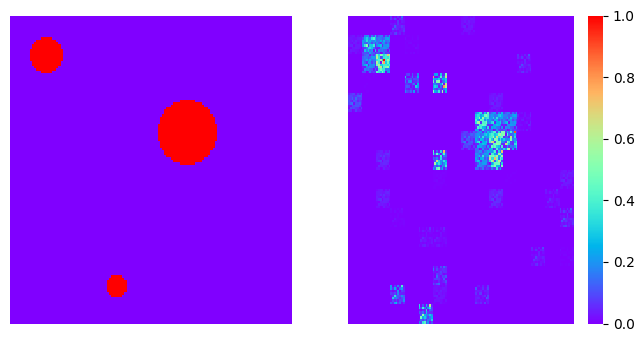

In [8]:
def RMSE_C(C_hat,C):
    ## estimation error in statistics
    d1,d2 = C.shape
    c1 = C_hat.reshape(d1*d2,-1)
    c2 = C.reshape(d1*d2,-1)
    res = la.norm(c1.squeeze()-c2.squeeze(),2) / np.sqrt(d1 *d2)
    return res
def RMSE_tensor(C_hat,C):
    m,n,d = C.shape
    c1 = C_hat.reshape(m*n*d,-1)
    c2 = C.reshape(m*n*d,-1)
    res = la.norm(c1.squeeze()-c2.squeeze(),2) / np.sqrt(m*n*d)
    return res
def error(beta_hat,beta,th = 0):
    ## non-threshold version
    ## return typeI error and Power
    # rmse_c = RMSE_C(beta_hat,beta)
    _len = beta.shape
    if len(_len)== 2:
        rmse_c = RMSE_C(beta_hat,beta)
        m,n = beta.shape
    else:
        rmse_c = RMSE_tensor(beta_hat,beta)
        m,n,d = beta.shape
    beta =  np.where(np.abs(beta) == 0 ,beta,1)
    beta_hat = np.asarray(beta_hat)
    if th == 0:
        tmp = np.where(np.abs(beta_hat) == 0 ,beta_hat,1)
    else:
        tmp = np.where(np.abs(beta_hat) > th,beta_hat,0)
        tmp = np.where(np.abs(tmp) < th,tmp,1)
    diff = beta - tmp
    mul = beta * tmp
    typeI = np.where(diff == -1)[0].shape[0]/np.where(beta == 0)[0].shape[0]
    Power = np.where(mul == 1)[0].shape[0]/np.where(beta == 1)[0].shape[0]
    return typeI,Power,rmse_c

A,B,kron_ab = func_kron_ab(a_hat,b_hat,R,p,d)
C_hat = kron_ab[-1]

def fun_normalization(data):
    data = np.abs(data)
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

plt.figure(figsize= (8,4))
ax = plt.subplot(1,2,1)
sns.heatmap(fun_normalization(C_true),cmap = "rainbow",cbar = False)
ax.set_xticks([])
ax.set_yticks([])
ax = plt.subplot(1,2,2)
sns.heatmap(fun_normalization(C_hat),cmap = "rainbow",cbar = True)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [45]:
R = 3
Rx = [Rearrange(x,p_list[0],d_list[0]) for x in X]
A, _, _ = la.svd(sum([Y[i] * Rx[i] for i in range(len(Rx))]))
A = A[:, :R]

In [66]:
from scipy.optimize import minimize, least_squares
from scipy.linalg import norm, qr
def b_next_iter(B,y,X,A):
    tot = 0
    for i in range(len(y)):
        # print(X[i].T.shape, A.shape, np.ravel(X[i].T @ A).shape, B.shape, np.ravel(B).T.shape)
        tot += y[i] - np.ravel(B).T @ np.ravel(X[i].T @ A)
    return 1/(2*len(y)) * tot**2
def a_next_iter(A,y,X,B,lmbda):
    tot = 0
    for i in range(len(y)):
        # print(X[i].shape, B.shape, np.ravel(X[i] @ B.T).shape, A.shape, np.ravel(A).T.shape)
        tot += y[i] - np.ravel(A).T @ np.ravel(X[i] @ B)
    return 1/(2*len(y)) * tot**2 + lmbda * norm(A, 1)

T = 5
B = np.ones((64, R))
lmbda = 0.4
kappa = 0.5
for i in range(T):
    tic = time.time()
    B = minimize(b_next_iter, np.ravel(B), args=(Y,Rx,A), method='BFGS').x.reshape(B.shape)
    toc = time.time()
    print(toc-tic)
    lmbda = lmbda * kappa * norm(B, ord='fro')
    # A = qr(minimize(a_next_iter, np.ravel(A), args=(Y,Rx,B,lmbda), method='L-BFGS-B', options={'maxiter': 5}).x.reshape(A.shape), mode='economic')[0]
    C = (A @ B.T).reshape(X[0].shape)
    print(C.shape)

7.224965333938599
(128, 128)
2.4424281120300293
(128, 128)
2.443833589553833
(128, 128)
2.4240126609802246
(128, 128)
2.412666082382202
(128, 128)


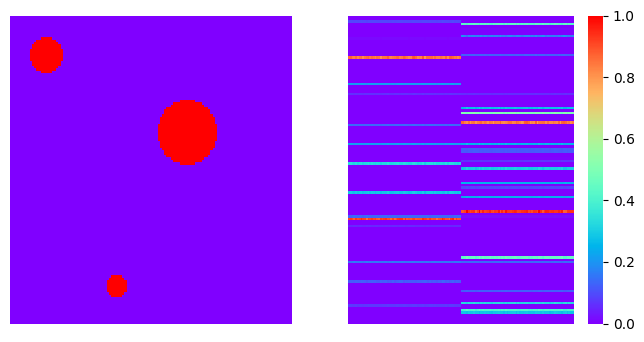

In [67]:
plt.figure(figsize= (8,4))
ax = plt.subplot(1,2,1)
sns.heatmap(fun_normalization(C_true),cmap = "rainbow",cbar = False)
ax.set_xticks([])
ax.set_yticks([])
ax = plt.subplot(1,2,2)
sns.heatmap(fun_normalization(C),cmap = "rainbow",cbar = True)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [16]:
np.squeeze

(256, 256)

In [14]:
X[0].shape

(128, 128)

In [32]:
b_vec_ls = least_squares(lambda b: b_next_iter(b,Y,Rx,A), B_vec)